In [1]:
import torch
import numpy
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(0,'/home/gsoc0/Adversarial_CapsNet_Pytorch/')

from model.cnn_net import *
from utils.training import *
from data.data import *

In [2]:
base_path = '/home/gsoc0/Adversarial_CapsNet_Pytorch/'
model_path = os.path.join(base_path, "weights")

args = {
    'DATASET_NAME':'mnist',
    'num_classes':10,
    
    'USE_CUDA': True if torch.cuda.is_available() else False,
    'BATCH_SIZE': 256,
    'N_EPOCHS': 100,
    'LEARNING_RATE_1': 1e-2,
    'LEARNING_RATE_2': 1e-2,
    'WEIGHTDECAY':5e-6,
    
    #Scheduler
    'USE_SCHEDULER':True,
    'sched_milestones':[8,20,30,40,50],
    'sched_gamma':0.1,
    
    #Loss Function
    'LAMBDA_recon': 1,
    'LAMBDA_class': 1,
    
    #For Decoder
    'num_features':160,
    'LReLU_negative_slope':0.1,
    'input_height':28,
    'input_width':28,
    'input_channel':1,
    'type':'plusCR',
    
}

#Setting Default Cuda Device
torch.cuda.set_device(1)

In [3]:
class Config:
    def __init__(self, dataset='mnist'):
        # CONV1
        self.conv1_in = 1
        self.conv1_out = 12
        self.conv1_kernel_size = 15

        # CONV2
        self.conv2_in = 12
        self.conv2_out = 16
        self.conv2_kernel_size = 8

        # FC1
        self.fc1_in = 7 * 7 * 16
        self.fc1_out = 784
        
        # FC1
        self.fc2_in = 784
        self.fc2_out = 160

torch.manual_seed(2)
config = Config()

net = CNNnet(args, config)

# net = torch.nn.DataParallel(net)
# net.load_state_dict(torch.load(os.path.join(model_path, 'CNNplusCR_mnist.pth'), map_location='cpu'))
    
if args['USE_CUDA']:
    net = net.cuda()
    

## Loading Dataset

In [4]:
dataloader = {}
dataloader['train'], dataloader['val'] = dataset(args)

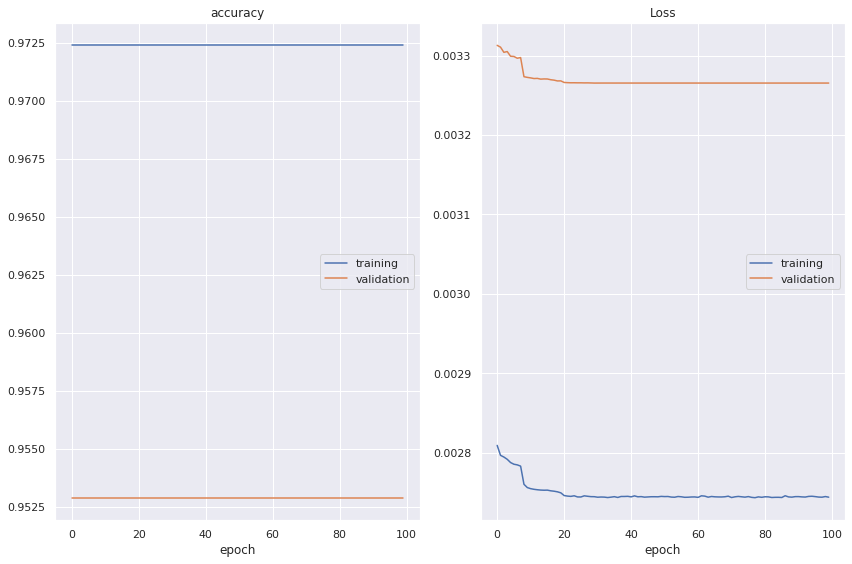

accuracy
	training         	 (min:    0.972, max:    0.972, cur:    0.972)
	validation       	 (min:    0.953, max:    0.953, cur:    0.953)
Loss
	training         	 (min:    0.003, max:    0.003, cur:    0.003)
	validation       	 (min:    0.003, max:    0.003, cur:    0.003)


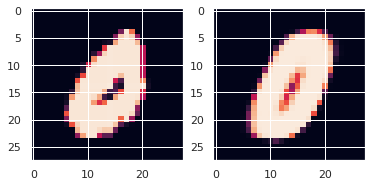

Weights of Reconstruction Layer: tensor([ 0.0003, -0.0001, -0.0001], device='cuda:1',
       grad_fn=<AsStridedBackward>)
Grads of Reconstruction Layer: tensor([ 9.4644e-09,  5.6145e-09, -1.5358e-07], device='cuda:1')


In [11]:
optimizer = torch.optim.Adam([
                {'params': net.decoder.parameters(), 'lr':args['LEARNING_RATE_2'], 'weight_decay':args['WEIGHTDECAY']},
#                 {'params': net.conv1.parameters()},
#                 {'params': net.conv2.parameters()},
#                 {'params': net.fc1.parameters()},
#                 {'params': net.fc2.parameters()},
            ], lr=args['LEARNING_RATE_1'])

train_clean(net, optimizer, dataloader, args)

In [14]:
torch.save(net.state_dict(), os.path.join(model_path, "CNNplusCR"+args['DATASET_NAME'] +".pth"))

In [12]:
#Modified Reconstructor

class Reconstructor(nn.Module):
    def __init__(self, net, args):
        super(Reconstructor, self).__init__()
        self.args = args
        self.reconstraction_layers = net.decoder.reconstraction_layers
        self.mean = torch.tensor(0.1307)
        self.std = torch.tensor(0.3081)
        if(args['USE_CUDA']):
            self.mean = self.mean.cuda()
            self.std = self.std.cuda()
        self.unnormalize = UnNormalize(self.mean, self.std)

    def forward(self, x, data):
        with torch.no_grad():
            classes = x.sum(2)
            classes = F.softmax(classes.squeeze(), dim=1)
            _, max_length_indices = classes.max(dim=1)

            if(self.args['type']=='plusCR'):
                masked = torch.sparse.torch.eye(10)
                if USE_CUDA:
                    masked = masked.cuda()
                masked = masked.index_select(dim=0, index=max_length_indices.squeeze().data)
                t = (x * masked[:, :, None]).view(x.size(0), -1)
                reconstructions = self.reconstraction_layers(t)
                reconstructions = reconstructions.view(-1, 1, self.args['input_channel']* self.args['input_width']* self.args['input_height'])

            elif(self.args['type']=='plusR'):
                x = x.view(x.size(0), -1)
                reconstructions = self.reconstraction_layers(x)
                reconstructions = reconstructions.view(-1, 1, self.args['input_channel']* self.args['input_width']* self.args['input_height'])
            
            expanded_data = data.view(x.size(0), 1, -1).expand(-1, 1, -1)
            unnormalized_data = self.unnormalize(expanded_data)
            l2_distances = torch.square((unnormalized_data - reconstructions)).sum(dim=(list(range(0, len(expanded_data.shape)))[2:]))
            return l2_distances
    
    def adversarial_recon(self, x, data):
        with torch.no_grad():
            classes = x.sum(2)
            classes = F.softmax(classes.squeeze(), dim=1)
            _, max_length_indices = classes.max(dim=1)
            if(self.args['type']=='plusCR'):
                masked = torch.sparse.torch.eye(10)
                if USE_CUDA:
                    masked = masked.cuda()
                masked = masked.index_select(dim=0, index=max_length_indices.squeeze().data)
                t = (x * masked[:, :, None]).view(x.size(0), -1)
                reconstructions = self.reconstraction_layers(t)
                reconstructions = reconstructions.view(-1, 1, self.args['input_channel']* self.args['input_width']* self.args['input_height'])
            
                
            elif(self.args['type']=='plusR'):
                x = x.view(x.size(0), -1)
                reconstructions = self.reconstraction_layers(x)
                reconstructions = reconstructions.view(-1, 1, self.args['input_channel']* self.args['input_width']* self.args['input_height'])
            
            expanded_data = data.view(x.size(0), 1, -1).expand(-1, 1, -1)
            unnormalized_data = self.unnormalize(expanded_data)
            l2_distances = torch.square((unnormalized_data - reconstructions)).sum(dim=(list(range(0, len(expanded_data.shape)))[2:]))
            return l2_distances


class Model_for_Adversary(nn.Module):
    def __init__(self, net):
        super(Model_for_Adversary, self).__init__()
        self.net = net
        
    def forward(self, x):
        output, recons, masked = self.net(x)
        classes = output.sum(2)
        return classes
    
def L2_Distances(net, reconstructor, train_loader, adversary, args):
    net.eval()
    n_batch = len(train_loader)
    l2_distances_clean = []
    l2_distances_adversarial = []
    
    for batch_id, (data, target) in enumerate(tqdm(train_loader)):
        if(args['USE_CUDA']):
            data, target = data.cuda(), target.cuda()

        adv_data = adversary.perturb(data, target)
        output, _, _ = net(data)
        l2_distances_clean.append(reconstructor.adversarial_recon(output, data).view(-1, ).detach())
        output, _, _ = net(adv_data)
        l2_distances_adversarial.append(reconstructor.adversarial_recon(output, adv_data).view(-1, ).detach())

        
    l2 = {}
    l2['clean'] = torch.cat(l2_distances_clean, dim=0).cpu().numpy()
    l2['adversarial'] = torch.cat(l2_distances_adversarial, dim=0).cpu().numpy()
    
    return l2['clean'], l2['adversarial']

recon = Reconstructor(net, args)
model_for_adversary = Model_for_Adversary(net)
from advertorch.attacks import LinfPGDAttack


adversary = LinfPGDAttack(
    model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.3/0.3081,
    nb_iter=200, eps_iter=0.01/0.3081, rand_init=True, clip_min=-0.4242, clip_max=2.8215,
    targeted=False)

l2_distances = L2_Distances(net, recon, dataloader['val'], adversary, args)

100%|██████████| 40/40 [01:19<00:00,  2.00s/it]


(0, 200)

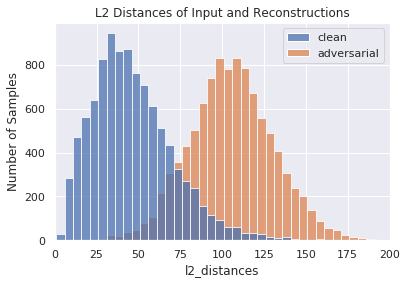

In [13]:
import seaborn as sns
clean_l2 = l2_distances[0]#[list(range(0,20000,2))]
adversarial_l2 = l2_distances[1]#[list(range(1,19999,2))]

fig, ax = plt.subplots()
sns.set_theme()
sns.histplot({'clean':clean_l2, 'adversarial':adversarial_l2}, bins=range(1, 200, 5), ax=ax, kde=False)
ax.set_xlabel('l2_distances')
ax.set_ylabel('Number of Samples')
ax.set_title('L2 Distances of Input and Reconstructions')
ax.set_xlim([0, 200])